# Network Latency Prediction: Horizontal Partitioning Approach

This notebook demonstrates the horizontal partitioning strategy for network latency prediction. We'll split data geographically into urban and rural subsets, train specialized models for each context, and compare their performance against a global baseline model.

## Table of Contents
1. [Data Loading and Exploration](#data-loading)
2. [Geographical Analysis](#geographical-analysis)
3. [Horizontal Data Partitioning](#horizontal-partitioning)
4. [Specialized Model Training](#model-training)
5. [Global Baseline Model](#baseline-model)
6. [Performance Evaluation](#evaluation)
7. [Comparative Analysis](#analysis)
8. [Conclusions](#conclusions)

## Setup and Imports

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Import project modules
from data_processing.data_loader import DataLoader
from data_processing.feature_engineering import FeatureEngineer
from models.geographical_model import GeographicalModel
from models.monolithic_model import MonolithicModel
from evaluation.model_evaluator import ModelEvaluator

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configuration
DATA_FILE = 'test_data.xlsx'
TEST_SIZE = 0.2
RANDOM_STATE = 42

print("Setup complete!")

Setup complete!


<a id="data-loading"></a>
## 1. Data Loading and Exploration

Let's start by loading our network latency dataset and exploring its geographical distribution.

In [2]:
# Initialize data loader
data_loader = DataLoader()

# Load the dataset
print("Loading dataset...")
raw_data = data_loader.load_dataset(DATA_FILE)

print(f"Dataset loaded successfully!")
print(f"Shape: {raw_data.shape}")
print(f"Columns: {list(raw_data.columns)}")

INFO:data_processing.data_loader:Loading dataset from test_data.xlsx
INFO:data_processing.data_loader:Successfully loaded dataset with 100 rows and 7 columns


Loading dataset...
Dataset loaded successfully!
Shape: (100, 7)
Columns: ['Tower ID', 'Signal Strength (dBm)', 'Network Traffic (MB)', 'Latency (ms)', 'User Count', 'Device Type', 'Location Type']


In [3]:
# Display basic information about the dataset
print("Dataset Info:")
print(raw_data.info())
print("\nFirst 5 rows:")
raw_data.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tower ID               100 non-null    object 
 1   Signal Strength (dBm)  99 non-null     float64
 2   Network Traffic (MB)   100 non-null    float64
 3   Latency (ms)           100 non-null    float64
 4   User Count             100 non-null    int64  
 5   Device Type            99 non-null     object 
 6   Location Type          100 non-null    object 
dtypes: float64(3), int64(1), object(3)
memory usage: 5.6+ KB
None

First 5 rows:


,Tower ID,Signal Strength (dBm),Network Traffic (MB),Latency (ms),User Count,Device Type,Location Type
0,T001,-73.782192,41.114894,131.986013,96,Mobile,Urban
1,T002,-33.449999,640.046307,25.986593,94,Mobile,Rural
2,T003,-48.760424,321.212421,40.709456,47,Desktop,Urban
3,T004,-58.093906,513.484984,180.725296,99,Laptop,Urban
4,T005,-89.078695,908.490809,125.221521,55,Tablet,Rural


In [4]:
# Preprocess the data
print("Preprocessing data...")
processed_data = data_loader.preprocess_data(raw_data)

print(f"Original data shape: {raw_data.shape}")
print(f"Processed data shape: {processed_data.shape}")
print(f"Rows removed during preprocessing: {len(raw_data) - len(processed_data)}")

INFO:data_processing.data_loader:Starting comprehensive data preprocessing
INFO:data_processing.data_loader:Handling missing values
INFO:data_processing.data_loader:Filled 1 missing values in 'Signal Strength (dBm)' with median: -66.94495523866355
INFO:data_processing.data_loader:Filled 1 missing values in 'Device Type' with mode: Mobile
INFO:data_processing.data_loader:Detecting and handling outliers
INFO:data_processing.data_loader:Converting and validating data types
INFO:data_processing.data_loader:Converted 'Signal Strength (dBm)' to float
INFO:data_processing.data_loader:Converted 'Network Traffic (MB)' to float
INFO:data_processing.data_loader:Converted 'Latency (ms)' to float
INFO:data_processing.data_loader:Converted 'User Count' to int
INFO:data_processing.data_loader:Converted 'Tower ID' to string
INFO:data_processing.data_loader:Converted 'Device Type' to string
INFO:data_processing.data_loader:Converted 'Location Type' to string
INFO:data_processing.data_loader:Preprocessi

Preprocessing data...
Original data shape: (100, 7)
Processed data shape: (100, 7)
Rows removed during preprocessing: 0


<a id="geographical-analysis"></a>
## 2. Geographical Analysis

Let's analyze the geographical distribution of our data and understand the differences between urban and rural contexts.

In [5]:
# Analyze geographical distribution
print("Geographical Distribution Analysis:")
location_counts = processed_data['Location Type'].value_counts()
print(location_counts)
print(f"\nPercentage distribution:")
print((location_counts / len(processed_data) * 100).round(2))

Geographical Distribution Analysis:
Location Type
Urban    56
Rural    44
Name: count, dtype: int64

Percentage distribution:
Location Type
Urban    56.0
Rural    44.0
Name: count, dtype: float64


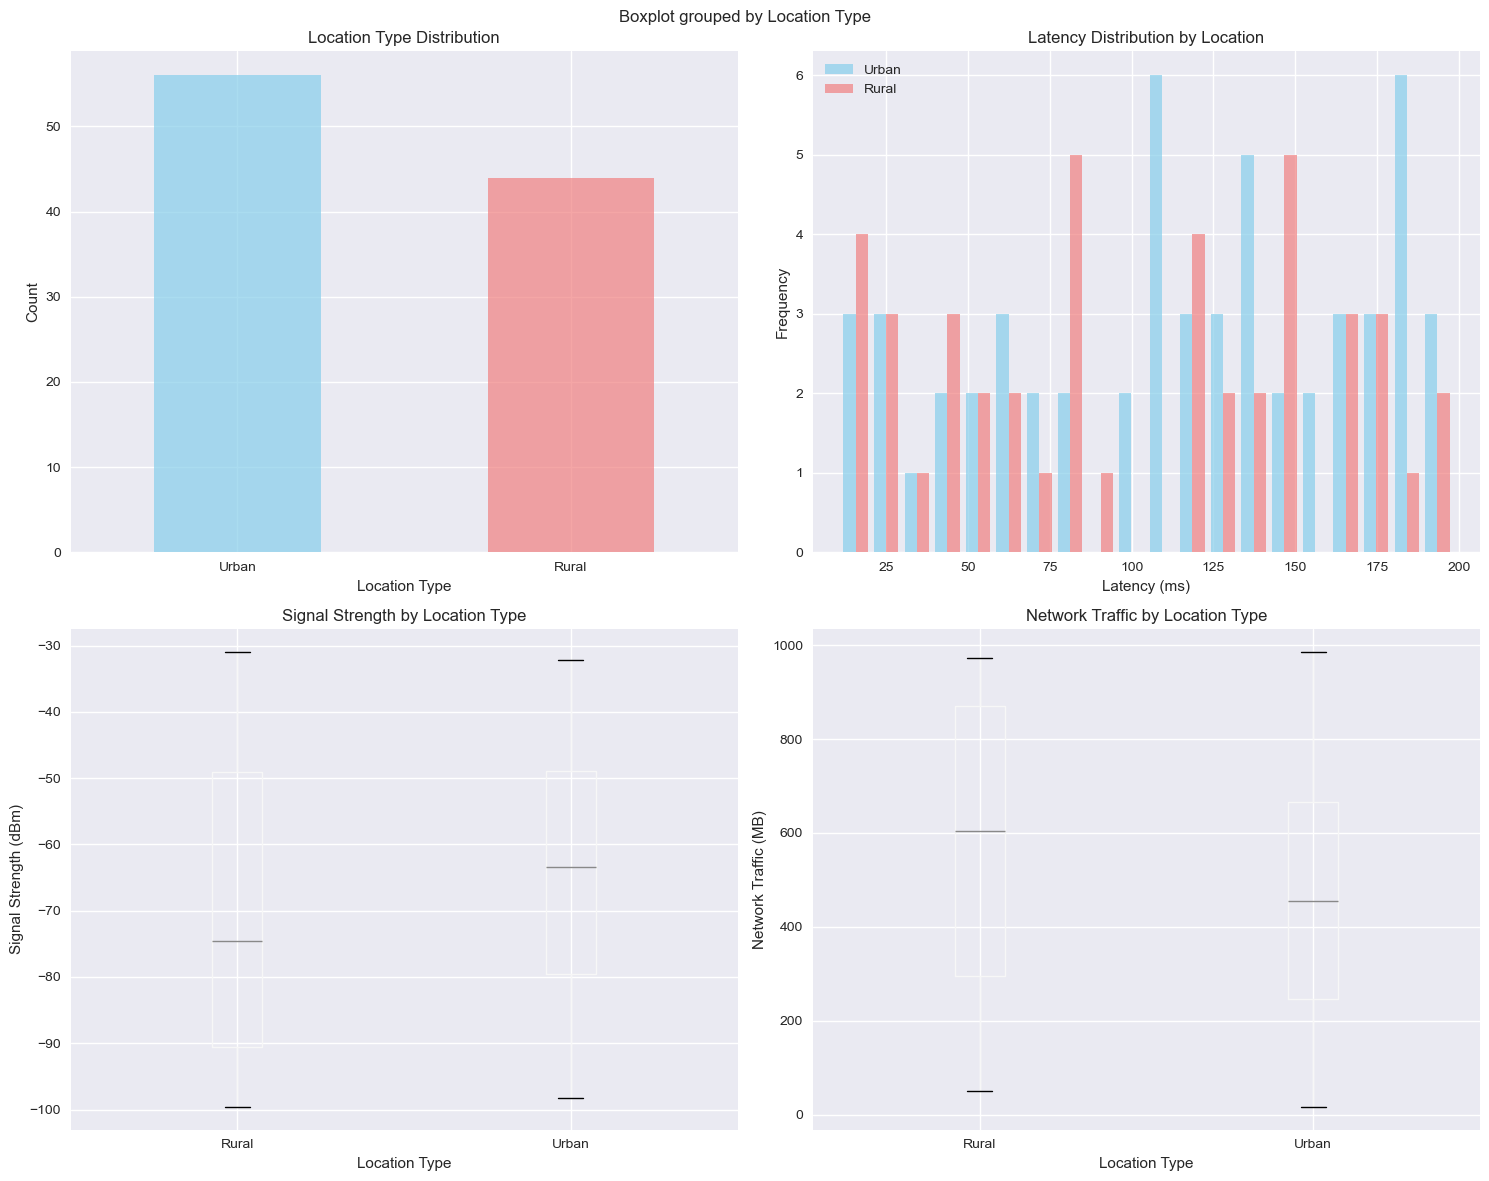

In [6]:
# Visualize geographical distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Geographical Analysis: Urban vs Rural Contexts', fontsize=16)

# Location type distribution
location_counts.plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'lightcoral'], alpha=0.7)
axes[0, 0].set_title('Location Type Distribution')
axes[0, 0].set_xlabel('Location Type')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=0)

# Latency distribution by location
urban_latency = processed_data[processed_data['Location Type'] == 'Urban']['Latency (ms)']
rural_latency = processed_data[processed_data['Location Type'] == 'Rural']['Latency (ms)']

axes[0, 1].hist([urban_latency, rural_latency], bins=20, alpha=0.7, 
                label=['Urban', 'Rural'], color=['skyblue', 'lightcoral'])
axes[0, 1].set_title('Latency Distribution by Location')
axes[0, 1].set_xlabel('Latency (ms)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Signal strength by location
processed_data.boxplot(column='Signal Strength (dBm)', by='Location Type', ax=axes[1, 0])
axes[1, 0].set_title('Signal Strength by Location Type')
axes[1, 0].set_xlabel('Location Type')
axes[1, 0].set_ylabel('Signal Strength (dBm)')

# Network traffic by location
processed_data.boxplot(column='Network Traffic (MB)', by='Location Type', ax=axes[1, 1])
axes[1, 1].set_title('Network Traffic by Location Type')
axes[1, 1].set_xlabel('Location Type')
axes[1, 1].set_ylabel('Network Traffic (MB)')

plt.tight_layout()
plt.show()